<div class="title">Práctica de laboratorio 1: SARSA y Q-Learning </div>
<div class="subtitle">Aprendizaje por Refuerzo</div>
<div class="author"> Autores:
    <ul>
        <li>Marlon Rodríguez Flor</li>
        <li>Alejandra Franco Solorio</li>
    </ul>
</div>

---

# GridWorld 2:

*GridWorld* es un mundo en forma de cuadrícula muy utilizado como entorno de pruebas para técnicas de Aprendizaje por Refuerzo. Dentro de esta cuadrícula hay varios tipos de celdas: iniciales, libres, obstáculos, terminales... ¡y ahora también agujeros de gusano! Los agentes tienen que llegar desde una celda inicial hasta otra terminal evitando los obtáculos y recorriendo una distancia mínima.

Paquetes necesarios para *GridWorld 2*:

In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rc('figure', figsize=(18, 4))

import warnings
warnings.filterwarnings('ignore')


np.random.seed(1)

Funciones auxiliares para visualizar información:

In [2]:
def printMap(world):
  # Visualiza el mapa de GridWorld
  m = "["
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if world.map[(i, j)] == 0:
        m += " O "
      elif world.map[(i, j)] == -1:
        m += " X "
      elif world.map[(i, j)] == 1:
        m += " F "
      elif world.map[(i, j)] == 2:
        m += " T "
    if i == world.size[0] - 1:
      m += "]\n"
    else:
      m += "\n"
  print(m)

def printPolicy(world, policy):
  # Visualiza la política con flechas
  p = "["
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if policy[i][j] == 0:
        p += " ^ "
      elif policy[i][j] == 1:
        p += " V "
      elif policy[i][j] == 2:
        p += " < "
      elif policy[i][j] == 3:
        p += " > "
      else:
        p += " x "
    if i == world.size[0] - 1:
      p += "]\n"
    else:
      p += "\n"
  print(p)

# Clase *World*:

Esta clase almacena la información del mundo:

*   *Map*: Matriz con la codificación del mundo con celdas libres (0), obstáculos (-1) y terminales (1)
*   *Size*: Vector con el tamaño de la matriz de codificación del mundo (ancho, alto)

Para crear un mundo hay que aportar los siguientes datos:

*   Tamaño del mapa (ancho, alto)
*   Lista de celdas terminales
*   Lista de celdas con obstáculos
*   Agujero de gusano

Notas:

* Cuando el agente cae en un obstáculo se queda atrapado para siempre en él
* Cuando el agente entra por un extremo del agujero de gusano sale por el otro extremo

Por ejemplo:

w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])

Crea un mundo de 10 filas y 10 columnas con un estado terminal (9, 9), dos obstáculos en (2, 4) y (4, 2) y un teletransporte entre (0, 2) y (9, 7).

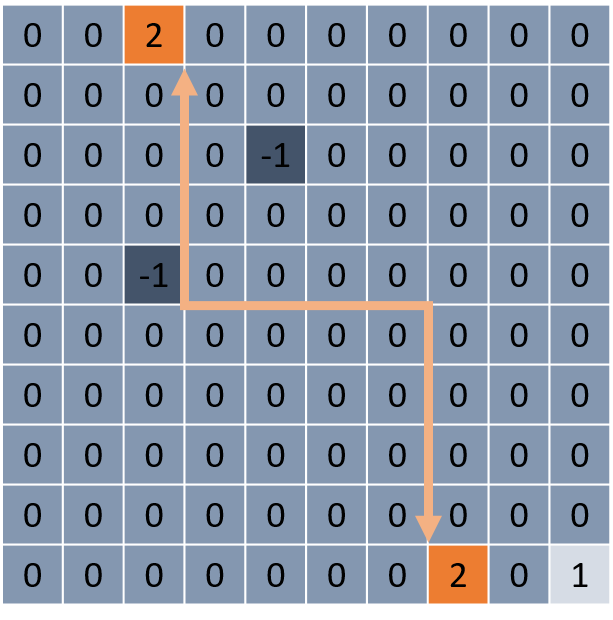

In [3]:
class World:

  def __init__(self, size, terminal, obstacle, hole):
    # Crea un mundo
    self.size = size
    self.map = {}
    for i in range(size[0]):
      for j in range(size[1]):
        # Estados libres
        self.map[(i, j)] = 0
        # Estados terminales
        for t in terminal:
          if i==t[0] and j==t[1]:
            self.map[(i, j)] = 1
        # Estados con obstáculos
        for o in obstacle:
          if i==o[0] and j==o[1]:
            self.map[(i, j)] = -1
        for h in hole:
          if i==h[0] and j==h[1]:
            self.map[(i, j)] = 2

Prueba de la clase *World*:

In [4]:
if __name__ == "__main__":
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
  printMap(w)

[ O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F ]



# Clase *Agent*:

Esta clase controla el agente que aprende por refuerzo en *GridWorld*.

Para crear un agente se necesitan los siguientes datos:

*   *World*: Mundo en el que se desenvuelve el agente.
*   *Initial State*: Estado inicial del agente.

Para controlar el agente se usan los siguientes métodos:

*   *nextState = move(state, action)*: Mueve el agente del estado *state* a un nuevo estado *nextState* aplicando una acción *action*.
*   *reward = reward(nextState)*: Devuelve el refuerzo *reward* que recibe el agente al transicionar al estado *nextState*.
*   *nextState, reward = checkAction(state, action)*: Comprueba a qué estado *nextState* y con qué refuerzo *reward* cambia el agente al aplicar la acción *action* en el estado *state*. Este método no cambia el estado interno del agente, por lo que puede usarse para hacer barridos del espacio de estados.
*   *nextState, reward = executeAction(action)*: Ejecuta la acción *action* en el estado actual y devuelve el nuevo estado *nextState* y el refuerzo *reward*. Este método cambia el estado interno del agente, por lo que sólo debe usarse cuando se realice un recorrido por el mundo.

Nota: Podéis hacer cambios en el agente (distribución de refuerzos, comportamiento en obstáculos...) buscando mejorar el rendimiento de los algoritmos.

In [5]:
class Agent:

  def __init__(self, world, initialState):
    # Crea un agente
    self.world = world
    self.state = np.array(initialState)

  def move(self, state, action):
    # Gestiona las transiciones de estados
    nextState = state + np.array(action)
    if nextState[0] < 0:
      nextState[0] = 0
    elif nextState[0] >= self.world.size[0]:
      nextState[0] = self.world.size[0] - 1
    if nextState[1] < 0:
      nextState[1] = 0
    elif nextState[1] >= self.world.size[1]:
      nextState[1] = self.world.size[1] - 1
    if self.world.map[(nextState[0], nextState[1])] == 2:
      aux = nextState
      for i in range(self.world.size[0]):
        for j in range(self.world.size[1]):
          if self.world.map[(i, j)] == 2 and (nextState[0] != i and nextState[1] != j):
            aux = np.array([i, j])
            nextState = aux
    return nextState

  def reward(self, nextState):
    # Gestiona los refuerzos
    if self.world.map[(nextState[0], nextState[1])] == -1:
      # Refuerzo cuando el agente intenta moverse a un obstáculo
      reward = -1 # ** Prueba varios valores **
    elif self.world.map[(nextState[0], nextState[1])] == 1:
      # Refuerzo cuando el agente se mueve a una celda terminal
      reward = 1 # ** Prueba varios valores **
    else:
      # Refuerzo cuando el agente se mueve a una celda libre
      reward = 0 # ** Prueba varios valores **
    return reward

  def checkAction(self, state, action):
    # Planifica una acción
    nextState = self.move(state, action)
    if self.world.map[(state[0], state[1])] == -1:
      nextState = state
    reward = self.reward(nextState)
    return nextState, reward

  def executeAction(self, action):
    # Planifica y ejecuta una acción
    nextState = self.move(self.state, action)
    if self.world.map[(self.state[0], self.state[1])] == -1:
      nextState = self.state
    else:
      self.state = nextState
    reward = self.reward(nextState) 
    return self.state, reward

Prueba de la clase *Agent*:

In [6]:
if __name__ == "__main__":
  # Crear el mundo
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
  printMap(w)
  # Crear el agente
  a = Agent(w, (0, 0))
  # Mover el agente en la diagonal principal
  for i in range(1, 5):
    # Mostrar cada nuevo estado y su recompensa
    print(a.executeAction((0, 1)))

[ O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F ]

(array([0, 1]), 0)
(array([9, 7]), 0)
(array([9, 8]), 0)
(array([9, 9]), 1)


# Trabajo:

En este trabajo vais a implementar los dos algoritmos más comunes de aprendizaje por refuerzo basados en el valor: SARSA y QLearning. Además, vais a probar ambos algoritmos en una serie de escenarios para evaluar su funcionamiento y comparar sus resultados.

## Mundos:

Para probar los algoritmos se ofrecen los siguientes mundos en varios tamaños:

*   Mundo 1: Laberinto fácil que se puede recorrer en zigzag
*   Mundo 2: Mundo con obstáculos aleatorios en el que el teletransporte acorta la distancia desde el inicio hasta el final
*   Mundo 3: Mundo con obstáculos aleatorios en el que el teletransporte no reduce la distancia desde el inicio hasta el final
*   Mundo 4: Laberinto difícil con caminos correctos y equivocados

Nota: Sentíos libres de utilizar todos o algunos de estos escenarios o directamente crear vuestros propios escenarios.

In [7]:
if __name__ == "__main__":

  # Mundo 1 pequeño: Laberinto fácil
  obstacles = []
  for j in range(0, 4):
    obstacles.append((j, 1))
  for j in range(1, 5):
    obstacles.append((j, 3))
  w1p = World((5, 5), [(4, 4)], obstacles, [])
  print("World 1: ")
  printMap(w1p)

  # Mundo 1 mediano: Laberinto fácil
  obstacles = []
  for i in [1, 5]:
    for j in range(0, 8):
      obstacles.append((j, i))
  for i in [3, 7]:
    for j in range(1, 9):
      obstacles.append((j, i))
  w1m = World((9, 9), [(8, 8)], obstacles, [])
  print("World 1: ")
  printMap(w1m)

  # Mundo 1 grande: Laberinto fácil
  obstacles = []
  for i in [1, 5, 9, 13, 17]:
    for j in range(0, 20):
      obstacles.append((j, i))
  for i in [3, 7, 11, 15, 19]:
    for j in range(1, 21):
      obstacles.append((j, i))
  w1g = World((21, 21), [(20, 20)], obstacles, [])
  print("World 1: ")
  printMap(w1g)

  # Mundo 2 pequeño: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))
  w2p = World((5, 5), [(4, 4)], obstacles, [(2, 0), (4, 2)])
  print("World 2: ")
  printMap(w2p)

  # Mundo 2 mediano: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))
  w2m = World((10, 10), [(9, 9)], obstacles, [(3, 1), (8, 6)])
  print("World 2: ")
  printMap(w2m)

  # Mundo 2 grande: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))
  w2g = World((21, 21), [(20, 20)], obstacles, [(6, 2), (18, 14)])
  print("World 2: ")
  printMap(w2g)

  # Mundo 3 pequeño: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))
  w3p = World((5, 5), [(4, 4)], obstacles, [(4, 0), (0, 4)])
  print("World 3: ")
  printMap(w3p)

  # Mundo 3 mediano: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))
  w3m = World((10, 10), [(9, 9)], obstacles, [(8, 1), (1, 8)])
  print("World 3: ")
  printMap(w3m)

  # Mundo 3 grande: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))
  w3g = World((21, 21), [(20, 20)], obstacles, [(18, 2), (2, 18)])
  print("World 3: ")
  printMap(w3g)

  # Mundo 4: Laberinto difícil
  obstacles = [(0,1),(0,3),(0,9),(0,15),(0,16),(0,17),(0,19),
               (1,1),(1,3),(1,4),(1,5),(1,6),(1,7),(1,9),(1,10),(1,11),(1,12),(1,13),(1,17),(1,19),
               (2,1),(2,9),(2,13),(2,15),(2,16),(2,17),(2,19),
               (3,1),(3,3),(3,5),(3,7),(3,9),(3,11),(3,16),(3,19),
               (4,3),(4,5),(4,7),(4,8),(4,9),(4,10),(4,11),(4,12),(4,13),(4,14),(4,16),(4,18),(4,19),
               (5,0),(5,1),(5,2),(5,3),(5,5),(5,9),(5,16),
               (6,5),(6,6),(6,7),(6,9),(6,10),(6,11),(6,12),(6,13),(6,14),(6,16),(6,17),(6,19),
               (7,0),(7,1),(7,2),(7,3),(7,5),(7,7),(7,9),(7,19),
               (8,3),(8,7),(8,8),(8,9),(8,12),(8,13),(8,14),(8,15),(8,16),(8,17),(8,18),(8,19),
               (9,1),(9,3),(9,5),(9,7),(9,11),(9,12),(9,19),(9,20),
               (10,1),(10,3),(10,5),(10,6),(10,7),(10,9),(10,11),(10,14),(10,15),(10,16),(10,17),
               (11,1),(11,3),(11,5),(11,9),(11,11),(11,13),(11,14),(11,17),(11,18),(11,19),
               (12,1),(12,5),(12,6),(12,8),(12,9),(12,11),(12,13),(12,19),
               (13,1),(13,2),(13,3),(13,4),(13,5),(13,8),(13,15),(13,16),(13,17),(13,19),
               (14,4),(14,7),(14,8),(14,10),(14,12),(14,13),(14,15),(14,19),
               (15,0),(15,1),(15,2),(15,6),(15,7),(15,10),(15,13),(15,14),(15,15),(15,17),(15,18),(15,19),(15,20),
               (16,2),(16,3),(16,5),(16,6),(16,7),(16,8),(16,9),(16,10),(16,11),(16,15),(16,17),
               (17,0),(17,3),(17,5),(17,9),(17,13),(17,14),(17,15),(17,17),(17,19),
               (18,0),(18,1),(18,5),(18,6),(18,7),(18,9),(18,10),(18,11),(18,15),(18,19),
               (19,1),(19,2),(19,4),(19,5),(19,11),(19,13),(19,14),(19,15),(19,16),(19,17),(19,18),(19,19),
               (20,7),(20,8),(20,9),(20,11),(20,19)]
  print("World 4: ")
  w4 = World((21, 21), [(20, 20)], obstacles, [])
  printMap(w4)

World 1: 
[ O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

World 1: 
[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

World 1: 
[ O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  

## Funciones Adicionales

Se añaden las siguientes funciones para facilitar las implementaciones de los algoritmos SARSA y Q-Learning.

In [8]:
def greedy(Q, S, epsilon, actions):
    '''
    Esta función nos permite obtener las acciones dependiendo de un epsilon.
    Si epsilon es menor que un número random entre 0 y 1 se realiza exploración,
    caso contrario se consulta la mejor acción (explotación).
    '''
    if np.random.rand() < epsilon:
        # print('Explore')
        return np.random.choice(len(actions)) 
    else:
        # print('Exploit')
        return np.where(Q[S[0], S[1]] == np.max(Q[S[0], S[1]]))[0][0]
    
def randInit(current_map, fixed = None):
    '''
    Esta función inicializa cada episodio en un espacio random del mapa (solo en espacios disponibles,
    no obstaculos, ni teletransporte, ni terminaciones). Si fixed esta dado Eg.: (0,0) inicializa en
    ese punto.
    '''
    if fixed is None:
        filtered_dict = {key: value for key, value in current_map.map.items() if value == 0}
        filtered_dict = list(filtered_dict.keys())
        rand_choice = np.random.choice(len(filtered_dict))
        return filtered_dict[rand_choice]
    return fixed

def getQfromMap(m, actions):
    '''
    Esta función permite crear la tabla Q(S,A), en este caso Q es un mapa Eg.: (0,0):[0,0.1,0.9,0]
    '''
    n_actions = len(actions)
    Q = m.map.copy()
    for k in Q.keys():
        Q[k] = np.zeros(n_actions)
    return Q

def testQConvergence(oldQ_values: np.ndarray, newQ_values: np.ndarray, tol = 0.00005):
    '''
    Esta función realiza nos devuelve True si la diferencia de Q_old y Q_new es menor a la toleracia
    lo cual indica que Q converge.
    '''
    return (np.abs(oldQ_values - newQ_values) < tol).all()

def printPolicy2(world, Q):
  '''
  Esta función se basa en printPolicy, sin embargo esta nos permite imprimir la política para
  nuesta Q.
  '''
  policy = np.zeros(world.size)
  for k, v in Q.items():
      if world.map[k] == 0:
          policy[k[0]][k[1]] = np.where(v == np.max(v))[0][0]
      elif world.map[k] == 2:
          policy[k[0]][k[1]] = -2
      elif world.map[k] == 1:
          policy[k[0]][k[1]] = -10
      else:
          policy[k[0]][k[1]] = -1

  # Visualiza la política con flechas
  p = ""
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if policy[i][j] == 0:
        p += " ^ "
      elif policy[i][j] == 1:
        p += " V "
      elif policy[i][j] == 2:
        p += " < "
      elif policy[i][j] == 3:
        p += " > "
      elif policy[i][j] == -2:
        p += " T "
      elif policy[i][j] == -10:
        p += " F "
      else:
        p += " X "
    if i == world.size[0] - 1:
      p += "\n"
    else:
      p += "\n"
  print(p)


# Todas las posibles acciones
actions = [(-1, 0), # 0 " ^ "
           (1, 0),  # 1 " V "
           (0, -1), # 2 " < "
           (0, 1)]  # 3 " > "

## SARSA:

*SARSA* (State-Action-Reward-State-Action) es un método basado en el valor que permite resolver problemas de aprendizaje por refuerzo. Al igual que el resto de métodos basados en el valor, *SARSA* calcula de forma iterativa la función de valor $Q(S,A)$ y, a partir de ella, determina la política óptima $\pi$.

*SARSA* recibe su nombre de las cinco variables implicadas en su función de actualización: el estado actual ($S_t$), la acción actual ($A_t$), el refuerzo actual ($R_t$), el siguiente estado ($S_{t+1}$) y la siguiente acción ($A_{t+1}$). Esta función de actualización tiene la siguiente forma:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t,A_t)]
\end{equation}

Nota: $\alpha$ es la longitud del episodio y $\gamma$ el factor de descuento.

El algoritmo *SARSA* sigue el siguiente esquema:

1.   Inicializar $Q(S,A)$ para todos los estados y acciones
2.   **Bucle** (repetir $3-9$ hasta la convergencia):
3.   Inicializar $S_t$
4.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
5.   **Bucle** (repetir $6-9$ hasta que $S_t$ sea terminal):
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Elegir $A_{t+1}$ en $S_{t+1}$ siguiendo la política derivada de $Q(S,A)$
8.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
9.   Tomar $S_{t+1}$ y $A_{t+1}$ como los nuevos $S_t$ y $A_t$

El algoritmo *SARSA* utiliza un parámetro $\epsilon \in (0, 1)$ para buscar un equilibrio entre exploración y explotación. A la hora de elegir $A_t$ en $S_t$, si un número aleatorio es menor que $\epsilon$, el algoritmo tomará una acción aleatoria; mientras que si ese número aleatorio es mayor que $\epsilon$, el algoritmo tomará la mejor acción conocida.

## Ejercicio 1:

Implementad el algoritmo SARSA para el agente y entorno definidos anteriormente.

A continuación, se presenta la función performSARSA() que corresponde a nuestra implementación del algoritmo SARSA. Es importante comentar que en esta implementación por default se utiliza un decay de epsilon.

In [9]:

def performSARSA(world: World, 
                 learning_rate = 0.8,
                 discount_factor = 0.95,
                 max_iter = 1000,
                 decay_exploration_rate = 0.995,
                 exploration_rate = 1,
                 actions=actions, 
                 is_terminal = 1,
                 fixed_init = None,
                 end_by_converge = False,
                 fixed_exploration_rate = False) -> dict:
    
    terminal = list(world.map.keys())[np.where(np.array(list(world.map.values())) == is_terminal)[0][0]]
    Q = getQfromMap(world, actions)

    converged = False
   
    statistics = {
       'steps_per_episode':[],
       'sum_total_rewards':[],
       'sum_total_abs_Q':[],
       'converge_at':[]
    }

    for _ in range(max_iter):
        # print('exploration_rate:', exploration_rate)
        ag = Agent(world, randInit(world, fixed=fixed_init))
        S = tuple(ag.state) # Current State
        A = greedy(Q, np.array(S), exploration_rate, actions) 
        prev_q_table = np.copy(np.array(list(Q.values())))

        total_steps = 0
        total_reward = 0
        while S != terminal:
            # Check Action
            check_S, check_R = ag.checkAction(S, actions[A])
            if check_R > -1: # Cae en un espacio disponible y ejecuta una accion
                new_S, reward = ag.executeAction(actions[A])
                new_S = tuple(new_S)
                new_A = greedy(Q, np.array(new_S), exploration_rate, actions)
                Q[tuple(S)][A] = Q[tuple(S)][A] + learning_rate*(reward + discount_factor*Q[tuple(new_S)][new_A] - Q[tuple(S)][A])
                S = new_S
                A = new_A  
            else: # Cae en un Obstaculo y solo actualiza la Q
                Q[tuple(S)][A] = Q[tuple(S)][A] + learning_rate*(check_R + discount_factor*Q[tuple(check_S)][A] - Q[tuple(S)][A])
                A = greedy(Q, np.array(S), exploration_rate, actions) 
                reward = check_R
            total_steps+=1
            total_reward+=reward

        # Collecting Some Statistics
        statistics['steps_per_episode'].append(total_steps)
        statistics['sum_total_abs_Q'].append(np.sum(np.abs(np.array(list(Q.values())))))
        statistics['sum_total_rewards'].append(total_reward)

        curr_q_table = np.copy(np.array(list(Q.values())))
        converged = testQConvergence(prev_q_table, curr_q_table)
        if converged and end_by_converge:
            print('Converged after {} episodes.'.format(_+1))
            statistics['converge_at'].append(_+1)
            break
        
        if not fixed_exploration_rate:
            exploration_rate = exploration_rate*decay_exploration_rate

        if end_by_converge and (_ >= (max_iter-1)):
            print('Not converge, max episodes reachead. ({} episodes)'.format(_+1))
            statistics['converge_at'].append(_+1)

    return Q, statistics

## Q-Learning:

*Q-Learning* es el método más conocido para resolver problemas de aprendizaje por refuerzo mediante un esquema basado en el valor. Este algoritmo recibe su nombre directamente de $Q(S,A)$, la función de valor que va actualizando a lo largo de su ejecución. *Q-Learning* es muy parecido a *SARSA*, pero tiene una función de actualización diferente:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma max_a{Q(S_{t+1}}, a) - Q(S_t,A_t)]
\end{equation}

En este caso, la acción $A_{t+1}$ en $S_{t+1}$ se toma buscando el máximo valor, en lugar de poder elegir entre exploración o explotación.

El algoritmo *Q-Learning* sigue el siguiente esquema:

1.   Inicializar $Q(S,A)$ para todos los estados y acciones
2.   **Bucle** (repetir $3-8$ hasta la convergencia):
3.   Inicializar $S_t$
4.   **Bucle** (repetir $6-8$ hasta que $S_t$ sea terminal):
5.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
8.   Tomar $S_{t+1}$ como el nuevo $S_t$

## Ejercicio 2:
Implementad el algoritmo Q-Learning para el agente y entorno definidos anteriormente.


A continuación, se presenta la función performQLearning() que corresponde a nuestra implementación del algoritmo Q-Learning. Es importante comentar que en esta implementación por default se utiliza un decay de epsilon.

In [10]:
# Resolución: Código de Q-Learning
def performQLearning(world: World, 
                 learning_rate = 0.8,
                 discount_factor = 0.95,
                 max_iter = 500,
                 decay_exploration_rate = 0.995,
                 exploration_rate = 1,
                 actions=actions, 
                 is_terminal = 1,
                 fixed_init = None,
                 end_by_converge = False,
                 fixed_exploration_rate = False) -> dict:
    
    terminal = list(world.map.keys())[np.where(np.array(list(world.map.values())) == is_terminal)[0][0]]
    Q = getQfromMap(world, actions)

    converged = False
   
    statistics = {
       'steps_per_episode':[],
       'sum_total_abs_Q':[],
       'sum_total_rewards':[],
       'converge_at':[]
    }

    for _ in range(max_iter):
        # print('exploration_rate:', exploration_rate)
        ag = Agent(world, randInit(world, fixed=fixed_init))
        S = tuple(ag.state) # Current State
        A = greedy(Q, np.array(S), exploration_rate, actions) 
        prev_q_table = np.copy(np.array(list(Q.values())))

        total_steps = 0
        total_reward = 0
        while S != terminal:
            # Check Action
            check_S, check_R = ag.checkAction(S, actions[A])
            if check_R > -1: # Cae en un espacio disponible y ejecuta una accion
                new_S, reward = ag.executeAction(actions[A])
                new_S = tuple(new_S)
                new_A = greedy(Q, np.array(new_S), exploration_rate, actions)
                Q[tuple(S)][A] = Q[tuple(S)][A] + learning_rate*(reward + discount_factor*Q[tuple(new_S)][np.where(Q[tuple(new_S)] == np.max(Q[tuple(new_S)]))[0][0]] - Q[tuple(S)][A])
                S = new_S
                A = new_A  
            else: # Cae en un Obstaculo y solo actualiza la Q
                Q[tuple(S)][A] = Q[tuple(S)][A] + learning_rate*(check_R + discount_factor*Q[tuple(check_S)][np.where(Q[tuple(check_S)] == np.max(Q[tuple(check_S)]))[0][0]] - Q[tuple(S)][A])
                A = greedy(Q, np.array(S), exploration_rate, actions) 
                reward = check_R
            total_steps+=1
            total_reward+=reward
            
        # Collecting Some Statistics
        statistics['steps_per_episode'].append(total_steps)
        statistics['sum_total_abs_Q'].append(np.sum(np.abs(np.array(list(Q.values())))))
        statistics['sum_total_rewards'].append(total_reward)

        curr_q_table = np.copy(np.array(list(Q.values())))
        converged = testQConvergence(prev_q_table, curr_q_table)
        if converged and end_by_converge:
            print('Converged after {} episodes.'.format(_+1))
            statistics['converge_at'].append(_+1)
            break
        
        if not fixed_exploration_rate:
            exploration_rate = exploration_rate*decay_exploration_rate

        if end_by_converge and (_ >= (max_iter-1)):
            print('Not converge, max episodes reachead. ({} episodes)'.format(_+1))
            statistics['converge_at'].append(_+1)


    return Q, statistics

## Funciones para plots del análisis:

In [11]:
def plotStepsByGroups(stats, title, showOutliers = False, group_size = 20):
    steps_per_episode = stats
    mean = np.mean(steps_per_episode)
    num_groups = len(steps_per_episode)//group_size
    x = []
    lasti = 1
    for i in range(num_groups):
        x+=[str(lasti)+'-'+str(lasti+group_size)]*group_size
        lasti = lasti+group_size+1
    diff = len(steps_per_episode) - len(x)
    x+=[str(lasti)+'-'+str(len(steps_per_episode))]*diff
    g = sns.boxplot(x=x, y=stats, showfliers=showOutliers, showmeans=True, meanprops={
                       'markerfacecolor':'red', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
    ax = g.axes
    ax.axhline(mean, ls='--', c='r', label = 'Promedio General de Pasos por Episodio:\n'+
               str(round(mean))+' Pasos')
    ax.set_title(title)
    ax.set_ylabel('Número de pasos')
    ax.set_xlabel('Episodios (Agrupado cada '+str(group_size)+' episodios)')
    plt.legend()

In [12]:
def plot_rewards_per_episode(rewardsSARSA, rewardsQLearning, title):
    plt.plot(rewardsSARSA, linestyle='-', label = 'SARSA')
    plt.plot(rewardsQLearning, linestyle='-', label = 'Q-Learning')
    plt.title(title)
    plt.ylabel('Total Reward')
    plt.ylabel('Episodes')
    plt.legend()
    plt.show()

## Análisis:

*SARSA* y *Q-Learning* son dos algoritmos muy parecidos, que se pueden aplicar en los mismos problemas y suelen encontrar soluciones similares. No obstante, los resultados de ambos algoritmos pueden diferir en ciertos problemas: por ejemplo, hay un problema llamado Cliffworld en el que SARSA encuentra soluciones más seguras y con menos valor, mientras que Q-Learning asume más riesgos y consigue más valor ([artículo interesante](https://medium.com/gradientcrescent/fundamentals-of-reinforcement-learning-navigating-cliffworld-with-sarsa-and-q-learning-cc3c36eb5830)).

## Ejercicio 3:

Analizad los resultados obtenidos por ambos algoritmos en los escenarios de prueba. Algunos posibles análisis se muestran a continuación, no es necesario que hagáis todos.

1.   Comentad el rendimiento que observáis en ambos algoritmos. ¿Qué problemas son capaces de resolver? ¿En cuáles no encuentran la solución óptima? ¿A qué se puede deber este comportamiento?

2.   Comentad las diferencias entre los algoritmos en los diferentes escenarios: ¿Cuál resuelve más escenarios? ¿Cuál converge más rápido? ¿Cuál genera más valor?

Nota: Las siguientes variables pueden ser interesantes para valorar los resultados: Diferencia entre la política resultante y la política óptima, número de iteraciones necesarias para converger, retorno total del problema y retorno obtenido en cada episodio.

3.   Comentad las diferencias cuando se aplica una mayor exploración ($\epsilon$ más alto) y una mayor explotación ($\epsilon$ más bajo). ¿Cuál converge más rápido? ¿Cuál obtiene más valor? ¿Qué estrategia piensas que podría usarse para explorar y explotar de forma más inteligente?

4.   Comentad las diferencias cuando se varían otros parámetros como el número de episodios, el ratio de aprendizaje ($\alpha$) o el factor de descuento ($\gamma$). ¿Qué valores dan mejores resultados?

**RESPUESTAS:**

A continuación, vamos a ver el comportameinto de los ambos algoritmos para los mapas medianos y el mundo 4, con el objetivo de responoder a las preguntas planteadas y que no tome demasiado tiempo correr todos los mundos. Se debe tomar en cuenta que por default ambos algoritmos realizan un decaimiento del epsilon (exploration rate), es decir, epsilon inicia con un valor de 1 y va decayendo con un rate de 0.9 para SARSA y 0.995 para Q-Learning, se utilizan estos valores ya que en general (empíricamente) hemos notado que tienen un mejor rendiemiento los algoritmos.

### World 1 Mediano

1. Vemos que ambos algoritmos son capaces de resolver este mundo, llegando a soluciones óptimas (solo existe una ruta óptima en este mundo) ya que logran llegar al estado terminal.
2. Vemos que el algoritmo de SARSA converge en 119 iteaciones, mientras que el Q-Learning converge en 44 iteraciones. En este sentido podemos notar que Q-Learning logra llegar a la solución óptima con mayor rapidez.

#### SARSA

In [13]:
sarsaQ_w1m, sarsa_stats_w1m = performSARSA(w1m, end_by_converge=True, 
                                   decay_exploration_rate=0.9, 
                                   fixed_init=(0,0))
printPolicy2(w1m, sarsaQ_w1m)

Converged after 119 episodes.
 V  X  >  >  V  X  >  >  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 >  >  ^  X  >  >  ^  X  F 



#### Q Learning

In [14]:
qLearning_w1m, qLearning_stats_w1m = performQLearning(w1m, end_by_converge=True, 
                                   decay_exploration_rate=0.995, 
                                   fixed_init=(0,0))
printPolicy2(w1m, qLearning_w1m)

Converged after 44 episodes.
 V  X  >  >  V  X  >  >  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 V  X  ^  X  V  X  ^  X  V 
 >  >  ^  X  >  >  ^  X  F 



A continuación, vemos el total de rewards alcanzado en cada uno de los episodios conforme va a avanzando el algoritmo. En la siguiente gráfica se puede aprercias que ambos van mas o menos similar.

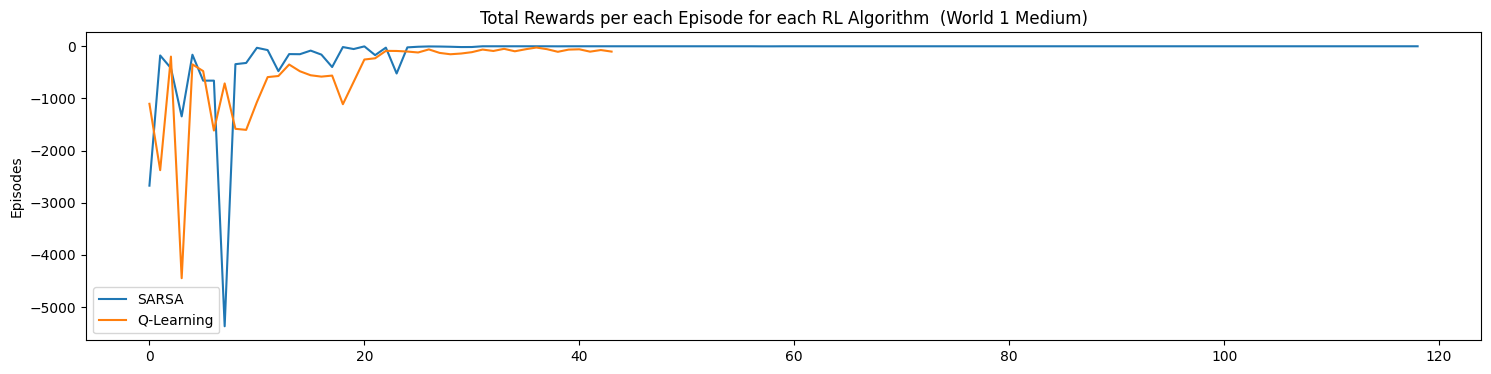

In [15]:
plot_rewards_per_episode(sarsa_stats_w1m['sum_total_rewards'], 
                         qLearning_stats_w1m['sum_total_rewards'],
                         title='Total Rewards per each Episode for each RL Algorithm  (World 1 Medium)')

Además, se muestran boxplots del número de pasos que realiza el algoritmos al ir avanzando los episodios. Se puede ver como el número de pasos va disminuyendo, esto se debe a que se va a alzando la solución óptima en Q por lo que en los últimos episodios se dan una menor cantidad de pasos (explota más) que al inicio (ya que que se explora más). Se puede ver que a pesar de que Q-Learning converge más rápido en promedio da una mayor cantidad de pasos en cada episodio.

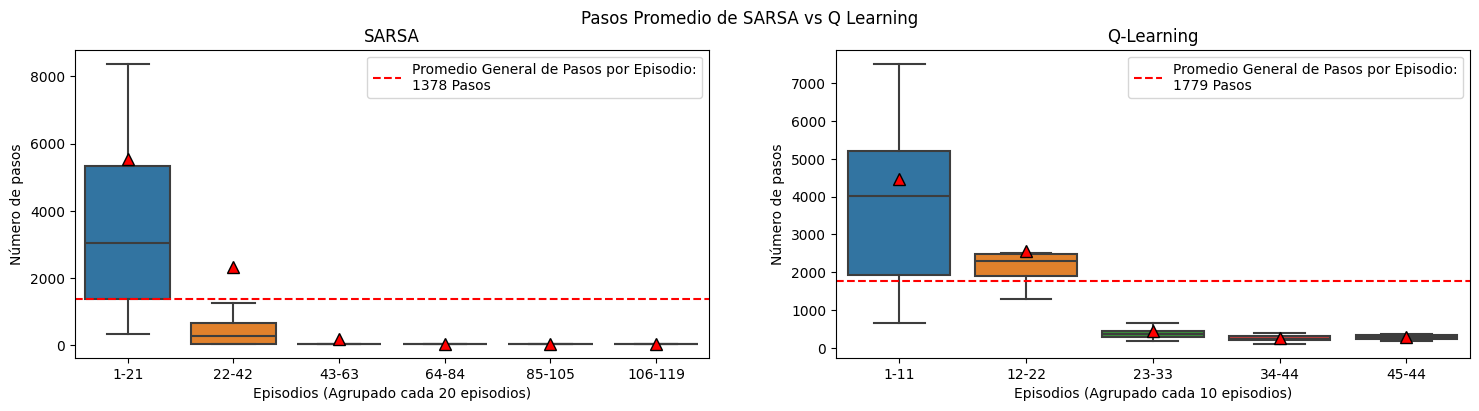

In [16]:
plt.suptitle('Pasos Promedio de SARSA vs Q Learning')
plt.subplot(1, 2, 1)
plotStepsByGroups(sarsa_stats_w1m['steps_per_episode'], title='SARSA', group_size = 20)
plt.subplot(1, 2, 2)
plotStepsByGroups(qLearning_stats_w1m['steps_per_episode'], title='Q-Learning', group_size = 10)

### World 2 Mediano

En este mundo lo ideal es tomar los teletransportes ya que permiten llegar de manera más rapida al estado terminal.

3. En este mundo vamos a analizar que sucede al bajar y aumentar el exploration rate (episilon). 
    - Con un epsilon fijo de 0.3: (más explotación)
        - Vemos que SARSA no logra converger, sin embargo logra resolver el ejercicio llegando a la solución y utilizando los teletransportes.
        - Q-Learning converge en 19 iteraciones alcanzando una solución óptima y utilizando los teletransportes adecuadamente.
    
    - Con un epsilon de 0.9: (más exploración)
        - SARSA no logra converger, pero llega a la solución y obtiene una solución no tan directa pero si utiliza los teletransportes.
        - Q-Learning converge en 38 iteraciones alcanzando una solución óptima y directa, utilizando los teletransportes.

Q-Learning obtiene un mayor valor ya que su solución es mejor en ambos casos que se favorece más la explotación o exploración.



#### SARSA

In [17]:
sarsaQ_w2m, sarsa_stats_w2m = performSARSA(w2m, end_by_converge=True, 
                                   fixed_exploration_rate=True,
                                   exploration_rate=0.9,
                                   fixed_init=(0,0))
printPolicy2(w2m, sarsaQ_w2m)

Not converge, max episodes reachead. (1000 episodes)
 V  ^  <  >  <  >  >  <  >  V 
 >  V  X  >  >  >  >  ^  ^  ^ 
 V  <  V  V  ^  >  ^  <  >  > 
 >  T  >  <  <  X  ^  ^  <  < 
 ^  <  <  <  <  X  ^  >  >  V 
 ^  >  V  <  <  <  ^  <  X  > 
 >  V  <  ^  V  X  ^  X  >  V 
 <  <  X  V  V  V  X  V  V  V 
 <  <  V  <  V  V  T  >  >  V 
 ^  <  <  >  >  >  <  >  >  F 



#### Q Learning

In [18]:
qLearning_w2m, qLearning_stats_w2m = performQLearning(w2m, end_by_converge=True, 
                                   fixed_exploration_rate=True,
                                   exploration_rate=0.9,
                                   fixed_init=(0,0))
printPolicy2(w2m, qLearning_w2m)

Converged after 38 episodes.
 V  V  <  <  <  V  <  <  ^  ^ 
 V  V  X  V  <  V  ^  ^  ^  ^ 
 V  V  <  <  V  <  ^  ^  ^  ^ 
 >  T  <  <  <  X  ^  ^  ^  ^ 
 ^  ^  <  ^  ^  X  ^  ^  ^  ^ 
 ^  ^  >  ^  V  <  ^  ^  X  V 
 ^  ^  >  V  V  X  ^  X  >  V 
 ^  ^  X  >  >  V  X  V  >  V 
 V  V  >  >  >  V  T  V  V  V 
 >  >  >  >  >  >  >  >  >  F 



En este caso, al tener un epsilon de 0.9 (más exploración) claramente se puede notar una mayor varianza en la suma total de los rewards para cada uno de los episodios. Se puede apreciar que esto le afecta mucho más a SARSA que a Q-Learnig que logra converger en unas pocas iteraciones.

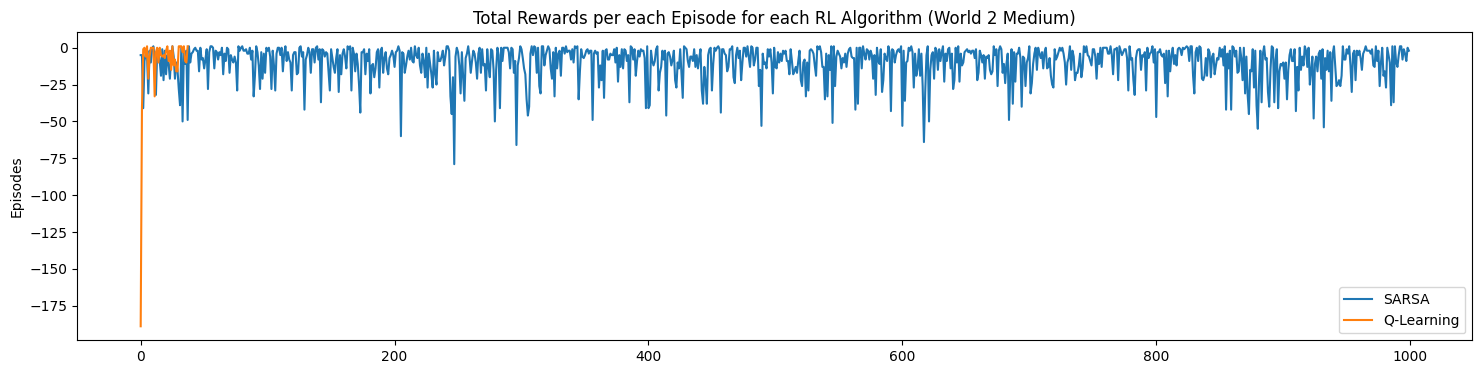

In [19]:
plot_rewards_per_episode(sarsa_stats_w2m['sum_total_rewards'], 
                         qLearning_stats_w2m['sum_total_rewards'],
                         title='Total Rewards per each Episode for each RL Algorithm (World 2 Medium)')

De forma similar, vemos que el número de pasos se mantiene igual en promedio para ambos algoritmos, lo cual es lo esperado ya que el 90% del tiempo pasamos realizando exploración y tan solo un 10% del tiempo realizamos explotación.

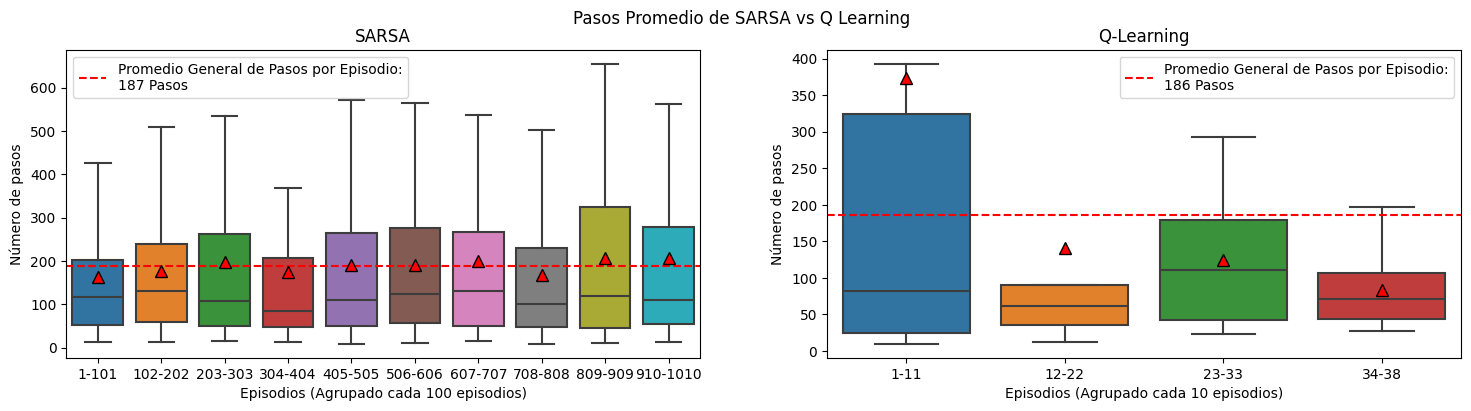

In [20]:
plt.suptitle('Pasos Promedio de SARSA vs Q Learning')
plt.subplot(1, 2, 1)
plotStepsByGroups(sarsa_stats_w2m['steps_per_episode'], title='SARSA', group_size = 100)
plt.subplot(1, 2, 2)
plotStepsByGroups(qLearning_stats_w2m['steps_per_episode'], title='Q-Learning', group_size = 10)

### World 3 Mediano

En este mundo idealmente no es útil tomar los teletransportes para llegar a la solución óptima. 

- Podemos notar que SARSA evita los teletransportes, y llegando a la solución de manera adecuada. Sin embargo, si se puede notar que realiza más pasos (algunos innecesarios) para llegar a la solución.
- Por otro lado, Q-Learnig logra llegar a la solución de manera más rápida sin utilizar los teletransportes y con un menor número de pasos, haciendo un mejor trabajo que SARSA. Además, se puede ver que se mueve más o menos en diagonal.
- Cabe mencionar que normalemente Q-Learning converge con mayor rapidez que SARSA, sin embargo, en este ejercicio ambos covergen 68-69 episodios.

#### SARSA

In [21]:
sarsaQ_w3m, sarsa_stats_w3m = performSARSA(w3m, end_by_converge=True, 
                                   decay_exploration_rate=0.9, 
                                   fixed_init=(0,0))
printPolicy2(w3m, sarsaQ_w3m)

Converged after 69 episodes.
 >  >  >  >  >  V  >  >  >  V 
 >  V  X  >  >  >  >  ^  T  V 
 >  <  >  ^  >  ^  <  X  >  V 
 ^  X  X  >  ^  <  <  V  >  V 
 V  <  X  V  ^  >  >  >  >  V 
 V  <  <  V  <  >  >  <  ^  V 
 ^  ^  X  V  V  X  >  V  X  V 
 >  V  V  V  ^  <  >  V  V  V 
 V  T  V  V  >  V  X  >  >  V 
 ^  ^  >  >  >  ^  >  >  >  F 



#### Q Learning

In [22]:
qLearning_w3m, qLearning_stats_w3m = performQLearning(w3m, end_by_converge=True, 
                                   decay_exploration_rate=0.995, 
                                   fixed_init=(0,0))
printPolicy2(w3m, qLearning_w3m)

Converged after 68 episodes.
 V  V  >  V  V  V  V  ^  V  ^ 
 >  V  X  V  V  V  V  >  T  V 
 >  >  >  >  V  V  V  X  V  < 
 V  X  X  V  V  V  V  V  V  V 
 V  V  X  >  V  >  V  V  V  V 
 >  >  >  >  >  >  V  V  >  V 
 V  V  X  V  V  X  >  V  X  V 
 >  >  V  >  >  >  >  V  V  V 
 >  T  >  V  V  V  X  V  V  V 
 >  >  >  >  >  >  >  >  >  F 



Se pude apreciar que SARSA tiende a estabilizarse con mayor rapidez que Q-Learning tomando en cuenta los rewards.

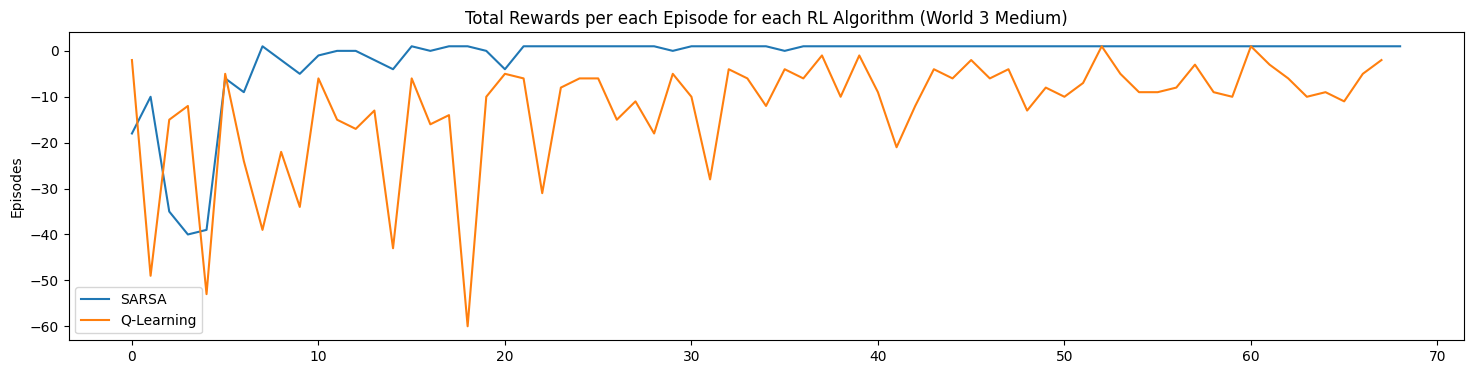

In [23]:
plot_rewards_per_episode(sarsa_stats_w3m['sum_total_rewards'], 
                         qLearning_stats_w3m['sum_total_rewards'],
                         title='Total Rewards per each Episode for each RL Algorithm (World 3 Medium)')

De igual forma, se puede apreciar que Q-Learning realiza una mayor cantidad de posos que SARSA en promedio.

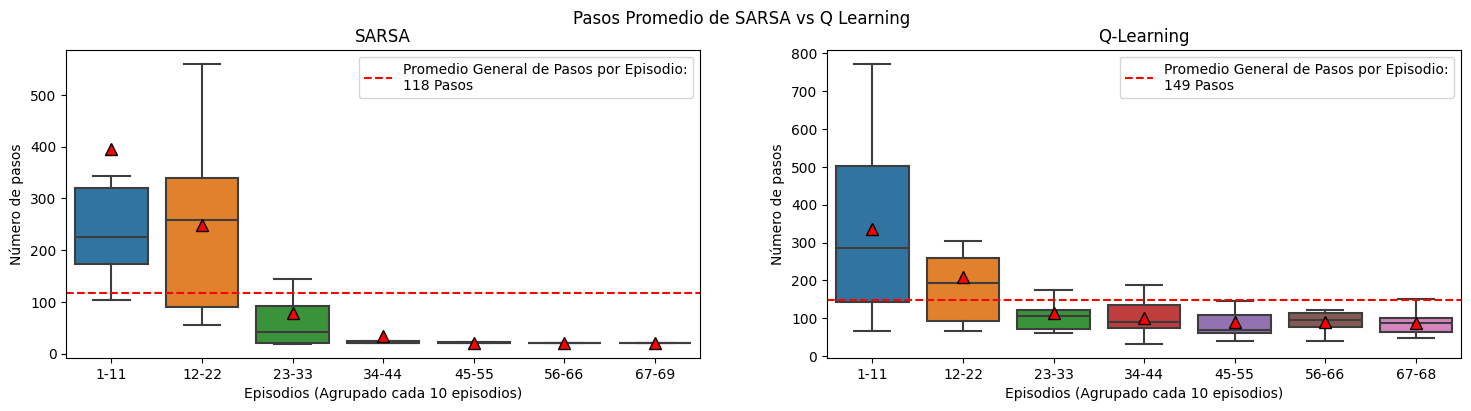

In [24]:
plt.suptitle('Pasos Promedio de SARSA vs Q Learning')
plt.subplot(1, 2, 1)
plotStepsByGroups(sarsa_stats_w3m['steps_per_episode'], title='SARSA', group_size = 10)
plt.subplot(1, 2, 2)
plotStepsByGroups(qLearning_stats_w3m['steps_per_episode'], title='Q-Learning', group_size = 10)

### World 4 (Laberinto)

Se puede apreciar que ambos algoritmos lograron llegar a una solución óptima, encontrando el camino en el laberinto. SARSA pudo converger en 155 episodios, mientras que Q-Learning lo hizo en 64 episodios. 

#### SARSA

In [25]:
sarsaQ_w4, sarsa_stats_w4 = performSARSA(w4, end_by_converge=True, 
                                   decay_exploration_rate=0.9, 
                                   fixed_init=(0,0))
printPolicy2(w4, sarsaQ_w4)

Converged after 155 episodes.
 V  X  V  X  >  ^  >  >  V  X  >  >  >  >  V  X  X  X  V  X  ^ 
 V  X  V  X  X  X  X  X  V  X  X  X  X  X  V  >  <  X  ^  X  V 
 V  X  >  >  V  <  <  <  V  X  >  <  <  X  V  X  X  X  V  X  ^ 
 V  X  ^  X  V  X  ^  X  ^  X  ^  X  >  <  >  V  X  V  <  X  V 
 >  >  ^  X  V  X  V  X  X  X  X  X  X  X  X  V  X  V  X  X  V 
 X  X  X  X  V  X  >  <  V  X  >  >  >  >  >  V  X  >  >  >  V 
 >  <  >  >  V  X  X  X  ^  X  X  X  X  X  X  ^  X  X  V  X  ^ 
 X  X  X  X  V  X  V  X  ^  X  >  V  <  <  <  <  <  <  ^  X  ^ 
 V  <  <  X  V  <  <  X  X  X  V  ^  X  X  X  X  X  X  X  X  ^ 
 V  X  ^  X  V  X  ^  X  >  >  V  X  X  V  <  <  >  >  <  X  X 
 V  X  ^  X  V  X  X  X  ^  X  V  X  V  <  X  X  X  X  ^  <  V 
 V  X  ^  X  V  X  >  >  ^  X  V  X  V  X  X  >  <  X  X  X  ^ 
 V  X  ^  <  <  X  X  ^  X  X  V  X  V  X  >  >  >  >  V  X  > 
 V  X  X  X  X  X  >  ^  X  >  >  >  >  >  ^  X  X  X  V  X  ^ 
 >  >  >  V  X  >  ^  X  X  ^  X  ^  X  X  ^  X  V  <  <  X  ^ 
 X  X  X  

#### Q Learning

In [26]:
qLearning_w4, qLearning_stats_w4 = performQLearning(w4, end_by_converge=True, 
                                   decay_exploration_rate=0.995, 
                                   fixed_init=(0,0))
printPolicy2(w4, qLearning_w4)

Converged after 64 episodes.
 V  X  V  X  ^  ^  >  >  V  X  ^  ^  ^  ^  ^  X  X  X  ^  X  ^ 
 V  X  V  X  X  X  X  X  V  X  X  X  X  X  ^  <  <  X  ^  X  ^ 
 V  X  >  >  V  <  <  <  <  X  V  <  V  X  ^  X  X  X  ^  X  ^ 
 V  X  ^  X  V  X  ^  X  ^  X  ^  X  ^  <  >  V  X  V  ^  X  ^ 
 >  >  ^  X  V  X  ^  X  X  X  X  X  X  X  X  V  X  ^  X  X  ^ 
 X  X  X  X  V  X  ^  <  <  X  >  >  >  >  >  V  X  >  V  <  ^ 
 >  >  >  >  V  X  X  X  ^  X  X  X  X  X  X  V  X  X  V  X  ^ 
 X  X  X  X  V  X  V  X  ^  X  V  <  <  <  <  <  <  <  <  X  ^ 
 V  <  <  X  V  <  <  X  X  X  V  <  X  X  X  X  X  X  X  X  ^ 
 V  X  ^  X  V  X  ^  X  >  >  V  X  X  V  <  <  <  <  <  X  X 
 V  X  ^  X  V  X  X  X  ^  X  V  X  V  <  X  X  X  X  ^  <  < 
 V  X  ^  X  V  X  >  >  ^  X  V  X  V  X  X  V  V  X  X  X  ^ 
 V  X  ^  <  <  X  X  ^  X  X  V  X  V  X  >  >  >  >  V  X  ^ 
 V  X  X  X  X  X  >  ^  X  >  >  >  >  >  ^  X  X  X  V  X  ^ 
 >  >  >  V  X  >  ^  X  X  ^  X  ^  X  X  ^  X  V  <  <  X  ^ 
 X  X  X  >

En cuanto a la suma de los rewards para cada episodio, vemos que ambos algoritmos se estabilizan rápidamente y no se ve demasiada variabilidad, por lo que podemos inferir que este problema resulta "más fácil" que los anteriores.

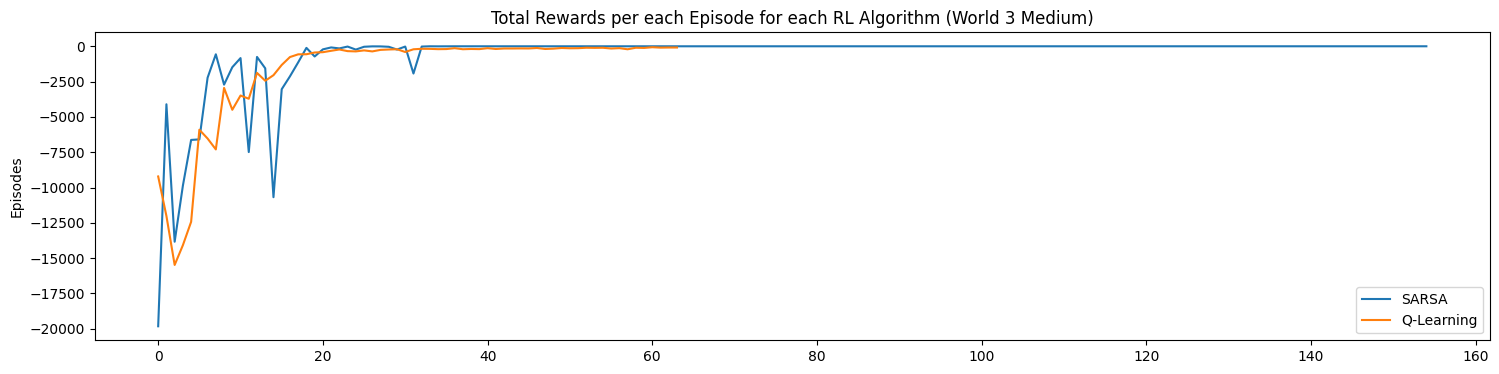

In [27]:
plot_rewards_per_episode(sarsa_stats_w4['sum_total_rewards'], 
                         qLearning_stats_w4['sum_total_rewards'],
                         title='Total Rewards per each Episode for each RL Algorithm (World 3 Medium)')

Así mismo, vemos que al inicio ambos algoritmos realizan una gran cantidad de pasos (exploración), después disminuyen en gran medida el número de pasos que realizan. En este caso SARSA realizó más pasos que Q-Learning en promedio.

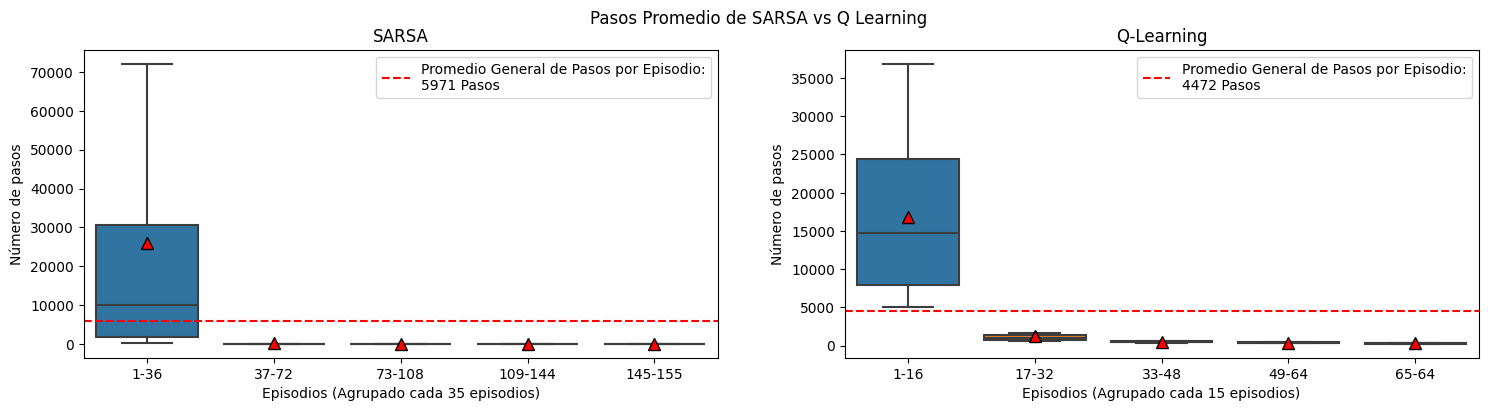

In [28]:
plt.suptitle('Pasos Promedio de SARSA vs Q Learning')
plt.subplot(1, 2, 1)
plotStepsByGroups(sarsa_stats_w4['steps_per_episode'], title='SARSA', group_size = 35)
plt.subplot(1, 2, 2)
plotStepsByGroups(qLearning_stats_w4['steps_per_episode'], title='Q-Learning', group_size = 15)

### Cliffworld

Por último, se probó el mapa de cliffworld para ver claramente una de las más grandes diferencias entre SARSA y Q-Learning, que es que SARSA tiene a explorar más, dandonos soluciones con una mayor cantidad de pasos. Esto se pudo observar claramente al utilizar el mundo de Cliff.

In [29]:
Cliffworld = World((4, 12), [(3,11)], [(3, i) for i in range(1,11)], [])
printMap(Cliffworld)

[ O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O  O  O 
 O  X  X  X  X  X  X  X  X  X  X  F ]



#### SARSA

Vemos que SARSA toma un camino "más seguro" y que no va pegado al borde.

In [30]:
sarsaQ_cliff, sarsa_stats_cliff = performSARSA(Cliffworld, end_by_converge=True, 
                                   decay_exploration_rate=0.8)
printPolicy2(Cliffworld, sarsaQ_cliff)

Converged after 31 episodes.
 >  >  >  >  >  >  >  >  >  >  V  V 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  V  V 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  V 
 ^  X  X  X  X  X  X  X  X  X  X  F 



#### Q Learning

Mientras que Q-Learning toma el camino más directo (más riesgoso) y pegado a los obstaculos.

In [31]:
qLearning_cliff, qLearning_stats_cliff = performQLearning(Cliffworld, end_by_converge=True, 
                                   decay_exploration_rate=0.995)
printPolicy2(Cliffworld, qLearning_cliff)

Converged after 14 episodes.
 V  V  >  V  >  >  V  V  >  >  V  V 
 >  >  >  >  >  >  >  >  >  V  V  V 
 >  >  >  >  >  >  >  >  >  >  >  V 
 ^  X  X  X  X  X  X  X  X  X  X  F 

